In [2]:
import torch
from pathlib import Path

from transformers import AutoTokenizer
from transformers import CLIPTextModel
from diffusers import (
    DDPMScheduler,
    AutoencoderKL,
    UNet2DConditionModel)

DEVICE = torch.device("cuda")
MODELS = Path("/projects/p_scads_llm_secrets/models")

In [3]:
# Load the tokenizer, scheduler and models
tokenizer = AutoTokenizer.from_pretrained(MODELS / "stable-diffusion-v1-5", subfolder="tokenizer")

text_encoder = CLIPTextModel.from_pretrained(MODELS / "stable-diffusion-v1-5", subfolder="text_encoder")

noise_scheduler = DDPMScheduler.from_pretrained(MODELS / "stable-diffusion-v1-5", subfolder="scheduler")

vae = AutoencoderKL.from_pretrained(MODELS / "stable-diffusion-v1-5", subfolder="vae")

unet = UNet2DConditionModel.from_pretrained(MODELS / "stable-diffusion-v1-5", subfolder="unet")

In [4]:
from diffusers import ControlNetModel

# Load controlnet
controlnet = ControlNetModel.from_pretrained(MODELS / "sd-controlnet-scribble")

In [5]:
from diffusers import StableDiffusionControlNetPipeline

# Initialize pipeline with all components
pipeline = StableDiffusionControlNetPipeline(
    unet=unet,
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    scheduler=noise_scheduler,
    controlnet=controlnet,
    # Safety checker is how the model knows not to generate anything objectionable
    safety_checker=None,
    requires_safety_checker=False,
    feature_extractor=None
).to(DEVICE)

## Canvas

In [8]:
from ipywidgets import HBox
from ipycanvas import RoughCanvas, hold_canvas

In [9]:
CANVAS_WIDTH = 512
CANVAS_HEIGHT = 512

canvas = RoughCanvas(width=CANVAS_WIDTH, height=CANVAS_HEIGHT, sync_image_data=True)
drawing = False
position = None

def on_mouse_down(x, y):
    global drawing
    global position
    global shape
    drawing = True
    position = (x, y)

def on_mouse_move(x, y):
    global drawing
    global position
    global shape
    if not drawing:
        return
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        position = (x, y)

def on_mouse_up(x, y):
    global drawing
    global position
    global shape
    drawing = False
    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)

canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_move(on_mouse_move)
canvas.on_mouse_up(on_mouse_up)

HBox((canvas,))

In [ ]:
sketch = canvas.get_image_data()

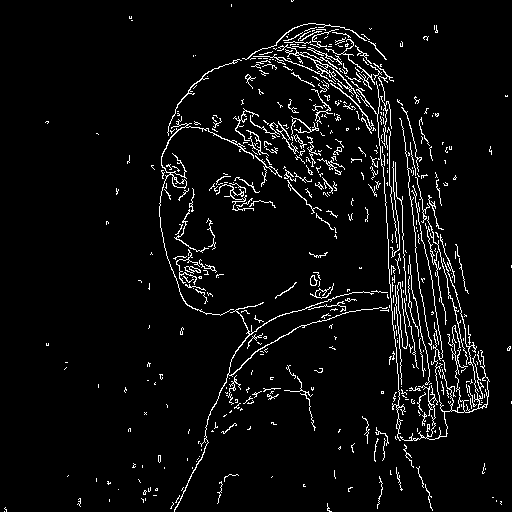

In [24]:
from PIL import Image, ImageOps
sketch = Image.open("vermeer_canny_edged.png")
sketch

## Generate

In [ ]:
pipeline(
    "A beautiful meadow",
    image=sketch, 
    num_inference_steps=50, 
    height=512,
    width=512,
    guidance_scale=7.5
).images[0]